In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets.samples_generator import make_gaussian_quantiles
from scipy.spatial.distance import squareform
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
import sklearn.datasets as skl
from mpl_toolkits.mplot3d import Axes3D

In [58]:
def init_ctrs_prob(points, k):
    '''
        Inint centers with the probability D^2(x)/sum(D^2(yi))

        x - current point
        yi - point from data
    '''
    centroids = np.zeros(shape=(1, 2)) 
    centroids[0] = points[np.random.randint( 
        points.shape[0]), :] 
    for c_id in range(1, k): 
        
        dst = np.empty((1, points.shape[0]), dtype=float)
        threshold = np.random.rand(1)
        for ind in range(points.shape[0]):
            dst[0][ind] = np.min(np.sum((centroids - points[ind, :]) ** 2, axis = 1))
        dst = np.cumsum(dst)
        if dst[-1] == 0:
            break
        dst /= dst[-1]
        for ind in range(dst.shape[0]):
            if dst[ind] > threshold:
                centroids = np.vstack((centroids, points[ind]))
                break 
    if (k - points.shape[0] > 0):
            centroids = np.vstack((centroids, 
                                   points[np.random.randint(0, points.shape[0], 
                                    k - points.shape[0])]))
    return centroids

def init_ctrs_random(points, k):
    return X[np.random.randint(points.shape[0], size=k)]

def find_clusters(X, n_centers, init='probability'):
    # 1. Choose the cluster based on random
    if init == 'random':
        centers = init_ctrs_random(X, n_centers)
    elif init == 'probability':
        centers = init_ctrs_prob(X, n_centers)
    else:
        return np.full(n_centers, np.nan), np.full(X.shape[0], np.nan)
    
    while True:
        # 2a. Assign labels based on closest center
        labels = np.argmin(cdist(centers, X, 'euclidean'), axis=0)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([[0, 0]])
        for i in range(n_centers):
          if (X[labels == i].size != 0):
            new_centers = np.concatenate((new_centers, np.array([X[labels == i].mean(0)])))
          else:
            new_centers = np.concatenate((new_centers, np.array([centers[i]])))
        new_centers = new_centers[1:]
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    return centers, labels

def tg(p1, p2):
    if p1[0] == p2[0]:
        if p1[1] < p2[1]:
            return np.inf
        elif p1[1] > p2[1]:
            return -np.inf
        else:
            return 0
    return (p2[1] - p1[1]) / (p2[0] - p1[0])

def WSS(X, labels, centers):
    return np.sum(np.array([np.sum((X[labels == i] - centers[i])**2) 
                                         for i in range(centers.shape[0])]))

def elbow_method(X, eps=0.2, init='probability'):
    wss = np.array([])
    count_cl = 1
    centers, labels = find_clusters(X, count_cl, init)
    wss = np.append(wss, WSS(X, labels, centers))
    count_cl += 1
    while True:
        centers, labels = find_clusters(X, count_cl, init)
        wss = np.append(wss, WSS(X, labels, centers))
        if (np.abs(tg(np.array([count_cl - 1, wss[count_cl - 2]]), 
                np.array([count_cl, wss[count_cl - 1]]))) < eps):
            count_cl -= 1
            break
        count_cl += 1
    #one more plot
    centers, labels = find_clusters(X, count_cl + 1, init)
    wss = np.append(wss, WSS(X, labels, centers))
    return wss, count_cl
    
def point_silhouette(ind_p, X, labels):
    if (np.sum(labels == labels[ind_p]) == 1):
        return 0
    unique, counts = np.unique(labels, return_counts=True)
    mrang = np.delete(unique, np.argwhere(unique == labels[ind_p]))
    a = np.sum(cdist(X[labels == labels[ind_p]], X[ind_p].reshape(1, 2), 'euclidean'), axis=0) / (counts[np.argwhere(unique == labels[ind_p])] - 1)
    b = np.min(np.array([(np.sum(cdist(X[labels == ind_c], X[ind_p].reshape(1, 2), 'euclidean'), axis=0)) 
                        / counts[np.argwhere(unique == ind_c)]
                         for ind_c in mrang]))
    return (b - a)/np.max(np.append(a, b))
    
def average_silhouette_method(X, max_amount_cl=12,  init='probability'):
    av_siluets = np.array([])
    count_cl = 2
    while count_cl != max_amount_cl:
        siluets = 0.0
        centers, labels = find_clusters(X, count_cl, init)
        for ind_p in range(X.shape[0]):
            siluets += point_silhouette(ind_p, X, labels)
        av_siluets = np.append(av_siluets, siluets/X.shape[0])
        count_cl += 1
    return av_siluets
        
def print_k_methods(X, eps=0.2, max_amout_cl = 12):
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    
    wss, count_cl = elbow_method(X, eps, init='random')
    axs[0,0].title.set_text("Random init")
    axs[0,0].plot(range(1, wss.shape[0] + 1), wss, 'kx-')
    axs[0,0].plot(count_cl, wss[count_cl - 1], 'og', label='Best count clasters')
    axs[0,0].set(ylabel = 'WSS')

    av_siluets = average_silhouette_method(X, max_amout_cl, init='random')  
    axs[0,1].title.set_text("Random init")
    axs[0,1].plot(range(2, max_amout_cl), av_siluets, 'mx-')
    axs[0,1].plot(np.argmax(av_siluets) + 2, np.max(av_siluets), 'sg', label='Best count clasters')
    axs[0,1].set(ylabel = 'Avg silhouette')

    wss, count_cl = elbow_method(X, eps, init='probability')
    axs[1,0].title.set_text("Probabilistic init")
    axs[1,0].plot(range(1, wss.shape[0] + 1), wss, 'kx-')
    axs[1,0].plot(count_cl, wss[count_cl - 1], 'og', label='Best count clasters')
    axs[1,0].set(xlabel = 'Values of K', ylabel = 'WSS')

    av_siluets = average_silhouette_method(X, max_amout_cl, init='probability') 
    axs[1,1].title.set_text("Probabilistic init") 
    axs[1,1].plot(range(2, max_amout_cl), av_siluets, 'mx-')
    axs[1,1].plot(np.argmax(av_siluets) + 2, np.max(av_siluets), 'sg', label='Best count clasters')
    axs[1,1].set(xlabel = 'Values of K', ylabel = 'Avg silhouette')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
        
def print_find_cl(X, n_centers=4):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.4)

    s_centers = init_ctrs_random(X, n_centers)
    centers, labels = find_clusters(X, n_centers, init='random')
    axs[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis');
    axs[0].scatter(s_centers[:,0], s_centers[:,1], c='violet', label='Start centers');
    axs[0].title.set_text("Random init")
    axs[0].legend()
    
    s_centers = init_ctrs_prob(X, n_centers)
    centers, labels = find_clusters(X, n_centers, init='probability')
    axs[1].scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis');
    axs[1].scatter(s_centers[:,0], s_centers[:,1], c='violet', label='Start centers');
    axs[1].title.set_text("Probabilistic init")
    axs[1].legend()
    
    plt.show()

def print_sdist_matrix(X, n_clusters, K=4):
    '''
        Print sorted distance matrix in two ways:
            1) Sorted by cluster
            2) Sorted by cluster and distance between the biggest cluster and others

        X - generated data
        n_clusters - initial count of clusters
        K - desired count of clusters
    '''
    fig, axs = plt.subplots(1, 2, num=1, figsize=(14, 5))
    plt.subplots_adjust(wspace=0.3)

    centers, labels = find_clusters(X, K)

    #Sorted by labels
    X3 = X[np.argsort(labels), :]
    X3 = squareform(pdist(X3))
    axs[1].title.set_text("Only sorted by cluster") 
    axs[1].matshow(X3,cmap='Purples_r')
    axs[1].set_xticks([])

    #Sorted by labels and dist between biggest cluster and current
    ind_l, count_in_l = np.unique(labels, return_counts=True)
    ind_maxc = ind_l[np.argmax(count_in_l)]
    permutation = (np.argsort(cdist(centers, [centers[ind_maxc]]), axis=0)).ravel()
    s_labels = np.copy(labels)
    for i in range(s_labels.shape[0]):
        s_labels[i], = np.where(permutation == s_labels[i])
    X3 = X[np.argsort(s_labels), :]
    X3 = squareform(pdist(X3))

    axs[0].title.set_text("Sorted by cluster and dist btw clrs")
    im = axs[0].matshow(X3,cmap='Purples_r')
    axs[0].set_xticks([])
    fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical',pad=0.06);
    fig.suptitle('K = ' + str(K) + '\n n_clusters = ' + str(n_clusters), x=0.425, y=1 , fontsize=14)

    plt.show() 

def predict_clusters():   # -> testing time ...
    pass

def best_clustwers(X):
    pass

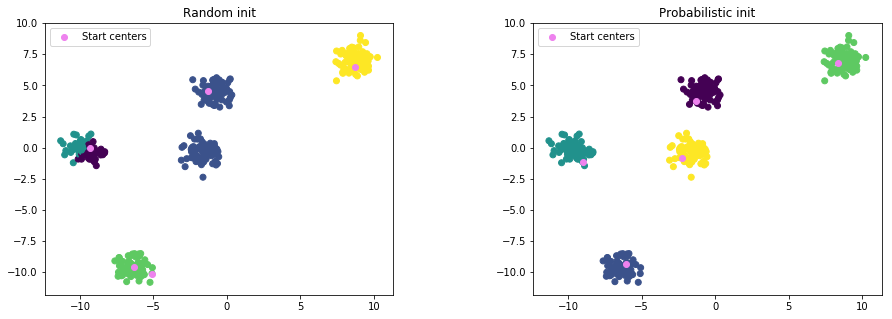

In [42]:
N_samples = 400
n_clusters = 5
cluster_std = 0.6 + N_samples/500000
random_state = 11
X, y_true = make_blobs(n_samples=N_samples, centers=n_clusters,
                       cluster_std=cluster_std, random_state=random_state)
print_find_cl(X, n_clusters)

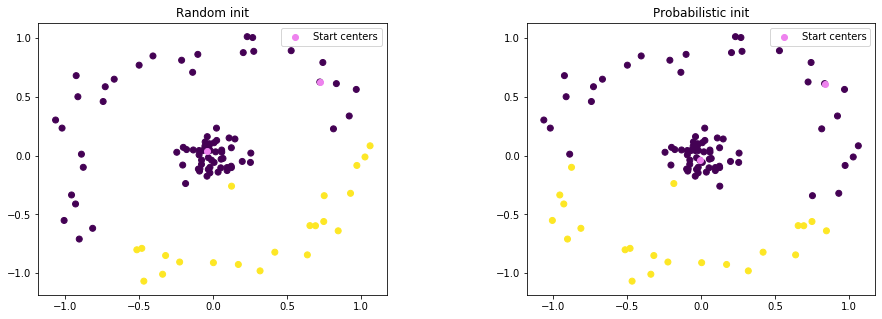

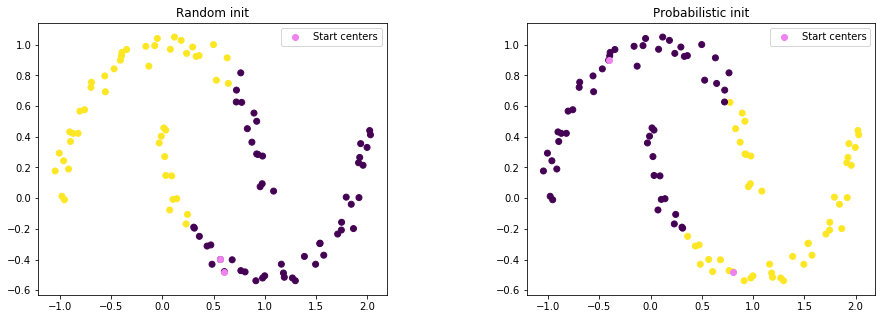

In [0]:
X, y_true = skl.make_circles(n_samples=100, shuffle=True, noise=0.1, random_state=1, factor=0.1)
print_find_cl(X, 2)
X, y_true = skl.make_moons(n_samples=100, shuffle=True, noise=0.05, random_state=0)
print_find_cl(X, 2)

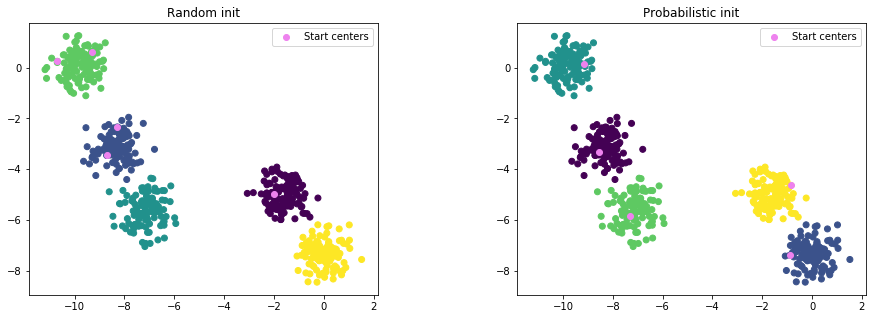

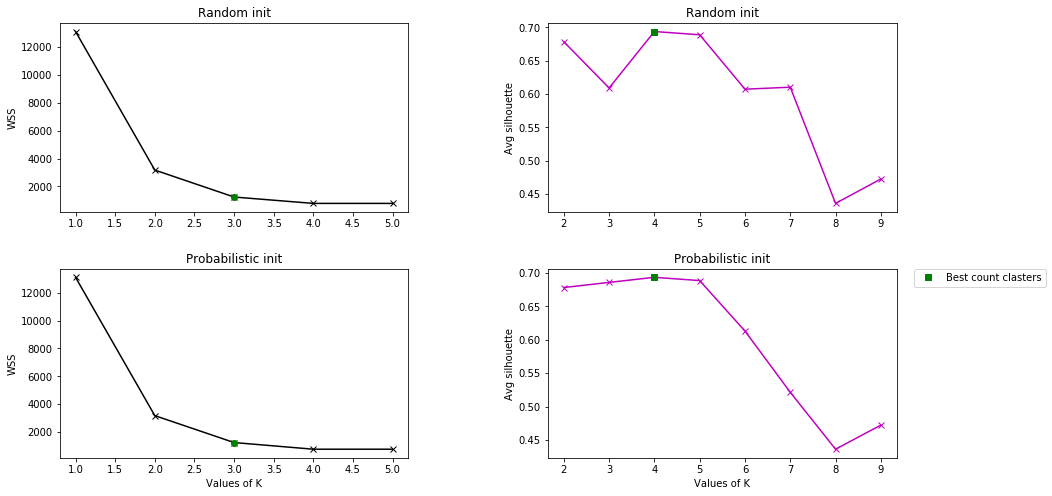

In [59]:
N_samples = 600
n_clusters = 5
cluster_std = 0.5
random_state = 9
X, y_true = make_blobs(n_samples=N_samples, centers=n_clusters,
                       cluster_std=cluster_std, random_state=random_state)
print_find_cl(X, n_clusters)
print_k_methods(X, eps=1000, max_amout_cl=10)

In [0]:
count_itp = 10
count_itk = 10
start_p = 1000
start_k = 2
inc_mul_p = 2
inc_add_k = 1
time_test = np.zeros((count_itp, count_itk))
for cp in range(count_itp):
    N_samples = start_p * (inc_mul_p ** cp)
    X, _ = make_blobs(n_samples=N_samples, centers=np.random.randint(low=3, high=8),
            cluster_std=0.5 + N_samples/500000, random_state=cp)
    for ck in range(count_itk):
        start_time = time.time()
        _, _ = find_clusters(X, start_k + inc_add_k * ck)
        print("{}/{}, {}/{}".format(N_samples, start_p * (inc_mul_p ** (count_itp-1)),
                                start_k + inc_add_k * ck, start_k + (count_itk-1)*inc_add_k))
        time_test[cp][ck] = time.time() - start_time

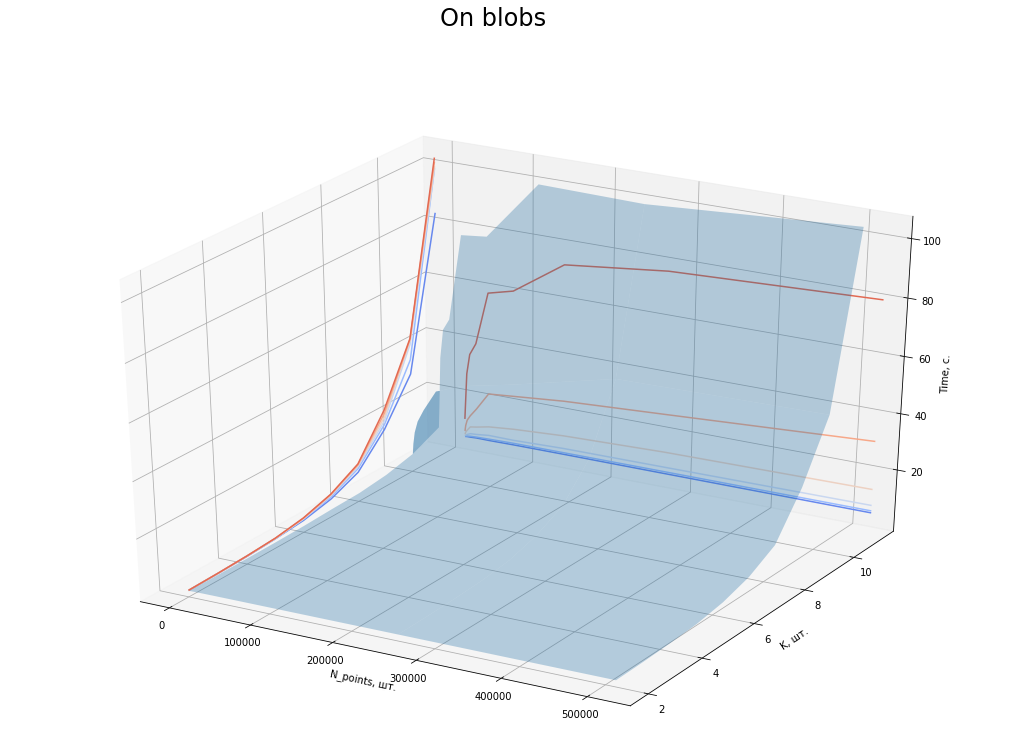

In [0]:
fig = plt.figure(figsize=(18, 12))
fig.suptitle('On blobs', fontsize=24)
ax = fig.add_subplot(111, projection='3d')
X = [start_p * (inc_mul_p ** (i)) for i in range(count_itp)]
Y = range(start_k, start_k + count_itk*inc_add_k, inc_add_k)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, time_test, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, time_test, zdir='x', offset=0,cmap=plt.cm.coolwarm)
cset = ax.contour(X, Y, time_test, zdir='y', offset=12,cmap=plt.cm.coolwarm)
ax.set_xlabel('N_points, шт.')
ax.set_ylabel('K, шт.')
ax.set_zlabel('Time, с.')
plt.show()

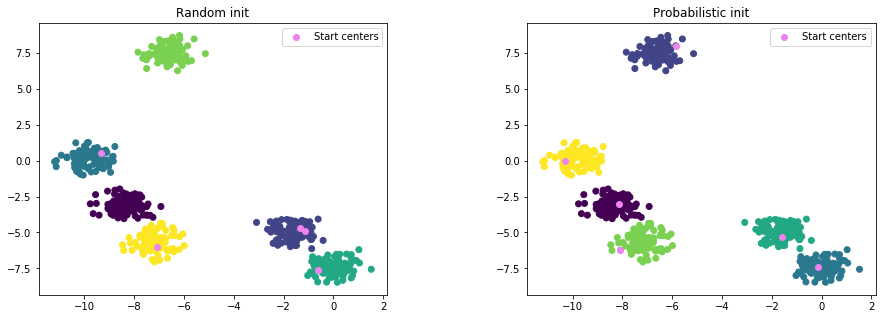

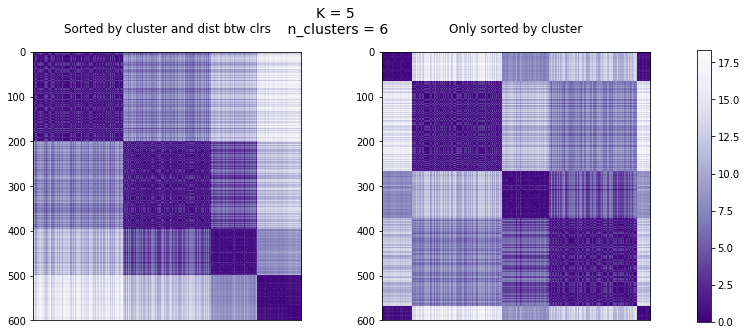

In [65]:
N_samples = 600
n_clusters = 6
cluster_std = 0.5
random_state = 9
X, y_true = make_blobs(n_samples=N_samples, centers=n_clusters,
                       cluster_std=cluster_std, random_state=random_state)
print_find_cl(X, n_clusters)
print_sdist_matrix(X, n_clusters=n_clusters, K=5)

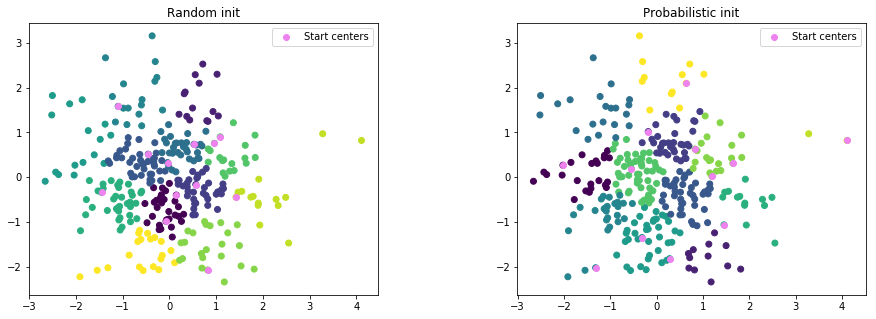

In [62]:
N_samples = 300
n_clusters = 12
random_state = 2
X, y_true = make_gaussian_quantiles(n_samples=N_samples, n_classes=n_clusters, random_state=random_state)
print_find_cl(X, n_clusters)

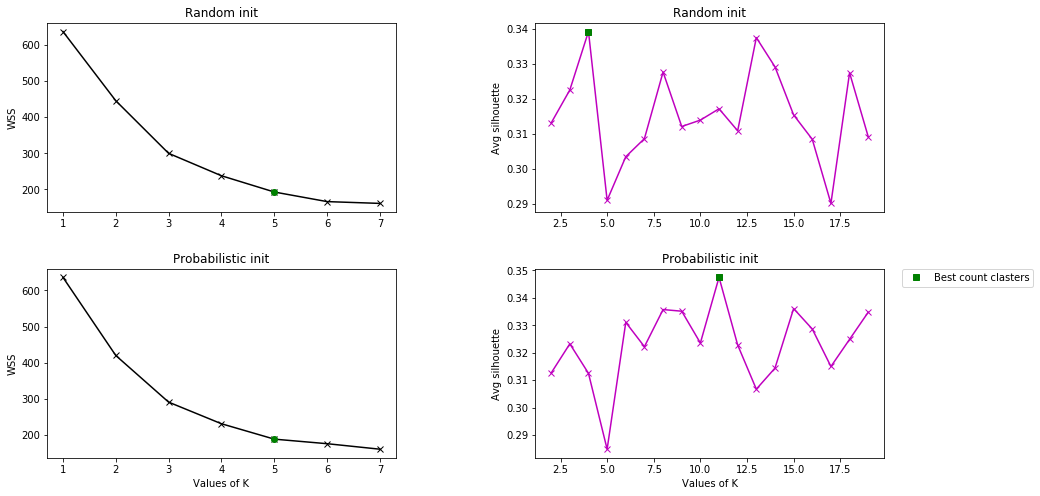

In [19]:
print_k_methods(X, eps=30, max_amout_cl=20)

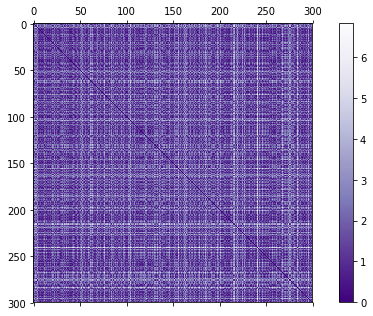

In [20]:
X2 = squareform(pdist(X))
fig = plt.figure(num=1, figsize=(8, 5))
plt.matshow(X2,fignum=1,cmap='Purples_r')
plt.colorbar(orientation='vertical', pad=0.06);

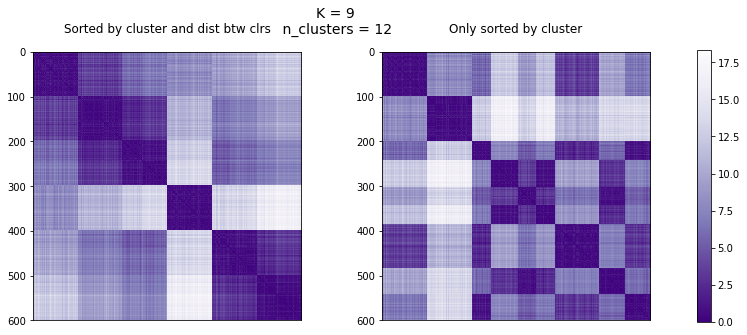

In [68]:
print_sdist_matrix(X, n_clusters=12, K=9)